### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
# plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## calculate jet latitude at each lon for each product

In [4]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'
idir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

tdats = ['JRA']#NCEP-DOE', 'MERRA']#'ERA5','NCEP-NCAR','UKESM', 
tdats = [ 'UKESMm2', 'UKESMm3'] #'UKESMEM',

ex = False

if ex:

    for yr in range(1940,2024):
        for tdat in tdats:
            try:
                w = xr.open_dataset(f'{sdir}{tdat}/{tdat}_wind_daily_1x1_{yr}.nc')
                q = w.sel(lat=slice(-70, -30))
                max_lat_indices = q.u10m.argmax(dim='lat')
                max_lats = q.u10m.lat[max_lat_indices]
                print(f'JETLAT_{tdat}_{yr}.nc')
                max_lats.to_netcdf(f'{idir}/JETLAT_{tdat}_{yr}.nc')
            except:
                print(f'no for {tdat} {yr}')

## get mean ts for the timeseries

In [5]:
ex = True

def make_yearlist(tdat, yrst = 1980, yrend = 2019, baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/JETLAT_{tdat}_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

dss = ['NCEP-DOE','ERA5','NCEP-NCAR','UKESM','MERRA','JRA']
dss = ['UKESMEM']

if ex:
    for ds in dss:
        print(ds)
        tdat = xr.open_mfdataset(make_yearlist(ds))
        tdat_fy = tdat.groupby('time_counter.year').mean()
        tdat_djf = tdat.sel(time_counter=(tdat['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
        tdat_mam = tdat.sel(time_counter=(tdat['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
        tdat_jja = tdat.sel(time_counter=(tdat['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
        tdat_son = tdat.sel(time_counter=(tdat['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()

        tdat_fy.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_djf.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_mam.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_jja.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_son.rename({"__xarray_dataarray_variable__": "lat"})

        tdat_fy.to_netcdf(f'{idir}/{ds}_mnjet_FY.nc')
        tdat_djf.to_netcdf(f'{idir}/{ds}_mnjet_DJF.nc')
        tdat_mam.to_netcdf(f'{idir}/{ds}_mnjet_MAM.nc')
        tdat_jja.to_netcdf(f'{idir}/{ds}_mnjet_SON.nc')
        tdat_son.to_netcdf(f'{idir}/{ds}_mnjet_JJA.nc')
        





UKESMEM


## trends fxns

In [6]:
def moving_average(timeseries, n = 3):
    # Ensure n is valid and doesn't exceed the length of the timeseries
    if n <= 0 or n > len(timeseries):
        raise ValueError("Window size n must be between 1 and the length of the timeseries.")
    
    # Compute the n-point moving average
    return np.convolve(timeseries, np.ones(n) / n, mode='valid')


import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p


### check that trends are correct for ukesm - they are, ensemble has bigger trends than individual

In [7]:
tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_FY.nc')

(-0.04809489571642456,
 0.012482226584454192,
 -0.051219785575048915,
 0.0027658535199056)

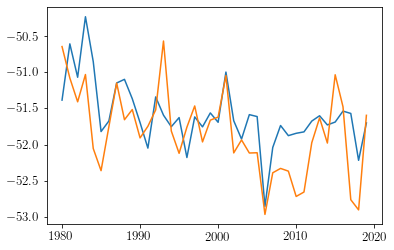

In [8]:
plt.figure()
tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_FY.nc')
plt.plot(tdat.year, np.nanmean(tdat.__xarray_dataarray_variable__.values, axis = 1))
tdat2 = xr.open_dataset(f'{idir}/UKESM_mnjet_FY.nc')
plt.plot(tdat.year, np.nanmean(tdat2.__xarray_dataarray_variable__.values, axis = 1))

ttest = np.nanmean(tdat2.__xarray_dataarray_variable__.values, axis = 1)[0:20]
give_trends(ttest)

ttest = np.nanmean(tdat.__xarray_dataarray_variable__.values, axis = 1)[0:20]
give_trends(ttest)


## get std deviation 

In [9]:
dss = ['NCEP-DOE','ERA5','NCEP-NCAR','UKESM','MERRA',]
dss = ['UKESM','ERA5']
dss = ['MERRA','JRA']
dss = ['UKESMm2','UKESMm3']
ex = False
if ex:
    for ds in dss:
        print(ds)
        tdat = xr.open_mfdataset(make_yearlist(ds))
        tdat_fy = tdat.groupby('time_counter.year').mean()#.std()
        tdat_std = (tdat_fy.std(dim = 'year'))

        tdat_std.to_netcdf(f'{idir}/{ds}_stdjet_FY.nc')


In [10]:
jra = xr.open_dataset(f'{idir}/JRA_stdjet_FY.nc')
era5 = xr.open_dataset(f'{idir}/ERA5_stdjet_FY.nc')
ncep = xr.open_dataset(f'{idir}/NCEP-NCAR_stdjet_FY.nc')
merra = xr.open_dataset(f'{idir}/MERRA_stdjet_FY.nc')
ukesm = xr.open_dataset(f'{idir}/UKESM_stdjet_FY.nc')
ukesm2 = xr.open_dataset(f'{idir}/UKESMm2_stdjet_FY.nc')
ukesm3 = xr.open_dataset(f'{idir}/UKESMm3_stdjet_FY.nc')
ukesm3 = xr.open_dataset(f'{idir}/UKESMm3_stdjet_FY.nc')

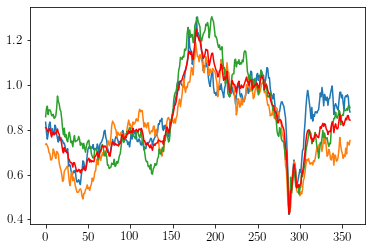

In [11]:
plt.plot(ukesm2.lon,ukesm2.__xarray_dataarray_variable__)
plt.plot(ukesm3.lon,ukesm3.__xarray_dataarray_variable__)
plt.plot(ukesm.lon,ukesm.__xarray_dataarray_variable__)

ukesmem = (ukesm2 + ukesm3 + ukesm) / 3

plt.plot(ukesmem.lon,ukesmem.__xarray_dataarray_variable__, 'r-')

save = False
if save:
    ukesmem.to_netcdf(f'{idir}/UKESMEM_stdjet_FY.nc')

In [12]:
print(f'ukesm {np.nanmean(ukesm.__xarray_dataarray_variable__.values)}')
print(f'ukesm2 {np.nanmean(ukesm2.__xarray_dataarray_variable__.values)}')
print(f'ukesm3 {np.nanmean(ukesm3.__xarray_dataarray_variable__.values)}')
print(f'ukesmem {np.nanmean(ukesmem.__xarray_dataarray_variable__.values)}')
print(f'era5 {np.nanmean(era5.__xarray_dataarray_variable__.values)}')
print(f'ncep {np.nanmean(ncep.__xarray_dataarray_variable__.values)}')
print(f'merra {np.nanmean(merra.__xarray_dataarray_variable__.values)}')
print(f'jra {np.nanmean(jra.__xarray_dataarray_variable__.values)}')



ukesm 0.8618509034422023
ukesm2 0.8592946638644956
ukesm3 0.7971033220191127
ukesmem 0.8394162964419368
era5 0.8062364747774934
ncep 0.885501684278733
merra 0.801885609451626
jra 0.8127221721115045


## the actual picture for the paper

## fonts

In [13]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
plt.rcParams['text.usetex'] = False
plt.rc('font', **font)

fs = 12
# Set global font size
rcParams.update({
    'font.size': fs,            # Base font size
    'axes.titlesize': fs,       # Title size
    'axes.labelsize': fs,       # X/Y label size
    'xtick.labelsize': fs,      # X-axis tick label
    'ytick.labelsize': fs,      # Y-axis tick label
    'legend.fontsize': fs,      # Legend text
})


# Your Gill Sans font file
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Register the font
gill_font = font_manager.FontProperties(fname=gill_sans_path)
font_manager.fontManager.addfont(gill_sans_path)

# Get internal name (important for mathtext settings)
gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()

# Set mathtext to use your font
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = gill_font_name
rcParams['mathtext.it'] = gill_font_name
rcParams['mathtext.bf'] = gill_font_name

# Specify the paths to the gill Sans font files
gill_sans = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
# Create FontProperties object
gill_font = font_manager.FontProperties(fname=gill_sans)



## jetpos - ONLY 3 ROWS

MERRA  FY 1980-1999, -52.31219190350242, -0.02487323609445286, 0.17846201292471825
MERRA SIGNIFICANCE WARNING
MERRA  FY 1980-2019, -52.28075653169731, -0.0011213278592088127, 0.8693383856042689
MERRA SIGNIFICANCE WARNING
JRA  FY 1980-1999, -52.2512555507731, -0.016529536359925715, 0.35926841700167766
JRA SIGNIFICANCE WARNING
JRA  FY 1980-2019, -52.3076586154985, -0.00927785104199751, 0.17042718811422206
JRA SIGNIFICANCE WARNING
ERA5  FY 1980-1999, -52.0170132650897, -0.021273409197945622, 0.25142389403751314
ERA5 SIGNIFICANCE WARNING
ERA5  FY 1980-2019, -52.080794019949096, -0.010745490058669614, 0.12245234822042904
ERA5 SIGNIFICANCE WARNING
NCEP-NCAR  FY 1980-1999, -51.435589959120364, -0.02893510491989652, 0.1725893836695978
NCEP-NCAR SIGNIFICANCE WARNING
NCEP-NCAR  FY 1980-2019, -51.561163678668564, -0.01632348024767778, 0.03013901720349503
UKESM  FY 1980-1999, -51.420326388888896, -0.051219785575048915, 0.0027658535199056
UKESM  FY 1980-2019, -51.59463638117285, -0.0200534513758597

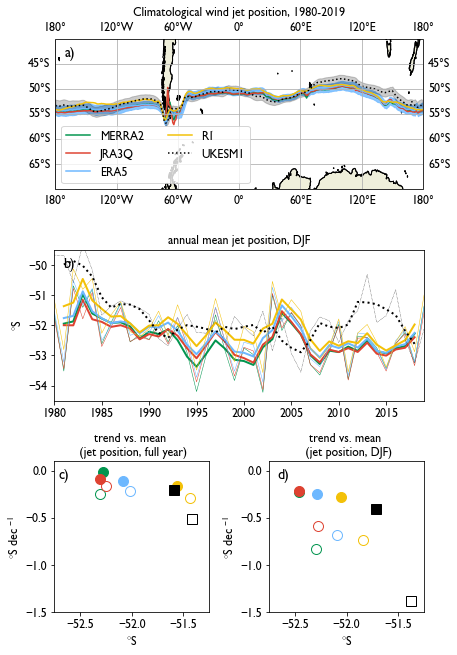

In [17]:
import coldic as cd
reload(cd)

dss = ['MERRA','JRA','ERA5','NCEP-NCAR','UKESM']
#dss = ['ERA5','UKESM']
#dss = ['ERA5']
# reload(cd)
fact = 1
fig = plt.figure(figsize=(6.15*fact, 9*fact))
gs = fig.add_gridspec(3, 2)

ax = fig.add_subplot(gs[0, 0:2], projection = ccrs.PlateCarree())
ax.set_extent([-180, 180, -70, -40], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabel_style = {'fontproperties': gill_font}
gl.ylabel_style = {'fontproperties': gill_font}

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='black')
#ax.add_feature(cfeature.OCEAN)

for ds in dss:
    
    if ds == 'UKESM':
        tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_FY.nc')
    else:
        tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_FY.nc')
    
    
    mnjet = np.roll(\
        np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'year').values),180)

    
    ax.plot(tdat.lon-180,mnjet, \
            color=cd.prod[ds]['col'], label = cd.prod[ds]['fnam'], 
            linestyle =cd.prod[ds]['linestyle'],\
            transform=ccrs.PlateCarree())
    if ds == 'UKESM':
        ts = xr.open_dataset(f'{idir}/UKESMEM_stdjet_FY.nc')
        stdjet  = np.roll(\
            np.squeeze(ts.__xarray_dataarray_variable__.values),180)
        ax.fill_between(tdat.lon-180,mnjet-stdjet,mnjet+stdjet,\
                        color=cd.prod[ds]['col'], alpha = 0.2)
    if ds == 'ERA5':
        ts = xr.open_dataset(f'{idir}/{ds}_stdjet_FY.nc')
        stdjet  = np.roll(\
            np.squeeze(ts.__xarray_dataarray_variable__.values),180)
        ax.fill_between(tdat.lon-180,mnjet-stdjet,mnjet+stdjet,\
                        color=cd.prod[ds]['col'], alpha = 0.8)
ax.set_aspect(4.91)



# ax4 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 0:2])
for ds in dss:

    if ds == 'UKESM':
        tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_DJF.nc')
    else:
        tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_DJF.nc')
        
    td = np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'lon').values)
    yr = tdat.year.values
    #moving_average(timeseries, n = 3)
    ax3.plot(tdat.year,td, color=cd.prod[ds]['col'], label = cd.prod[ds]['fnam'],\
            linestyle =cd.prod[ds]['linestyle'], linewidth = 0.5 )
    ax3.plot(yr[1:-1],moving_average(td), color=cd.prod[ds]['col'], label = cd.prod[ds]['fnam'],\
            linestyle =cd.prod[ds]['linestyle'], linewidth = 2 )
ax3.set_ylim([-54.5,-49.5])
ax3.set_xlim([1980,2020])





# ax6 = fig.add_subplot(gs[2, 0:2])
ax4 = fig.add_subplot(gs[2, 0:1])

for ds in dss:
    
    if ds == 'UKESM':
        tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_FY.nc')
    else:
        tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_FY.nc')
        
    a = np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'lon').values)[0:20]
    wym = np.mean(a)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(a)
    print(f'{ds}  FY 1980-1999, {wym}, {lin_slope}, {lin_p}')
    alph = 1
    SW = False
    if lin_p > 0.05:
        print(f'{ds} SIGNIFICANCE WARNING')
        SW = True

    mkz = 'o'; ms = 10
    if ds == 'UKESM': mkz = 's'; ms = 10
    ax4.plot(wym, lin_slope*10, color ='w', \
             marker = mkz, markersize = ms, markeredgecolor = cd.prod[ds]['col'], alpha = alph)    
    # if SW:
    #     ax4.plot(wym, lin_slope*10, color ='grey', \
    #          marker = 'x', markersize = ms+5)  
        
    a = np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'lon').values)
    wym = np.mean(a)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(a)
    print(f'{ds}  FY 1980-2019, {wym}, {lin_slope}, {lin_p}')
    alph = 1
    SW = False
    if lin_p > 0.05:
        print(f'{ds} SIGNIFICANCE WARNING')
        SW = True

    mkz = 'o'; ms = 10
    if ds == 'UKESM': mkz = 's'; ms = 10
    ax4.plot(wym, lin_slope*10, color =cd.prod[ds]['col'], \
             marker = mkz, markersize = ms, markeredgecolor = cd.prod[ds]['col'], alpha = alph)    
    # if SW:
    #     ax4.plot(wym, lin_slope*10, color ='grey', \
    #          marker = 'x', markersize = ms+5)  



ax5 = fig.add_subplot(gs[2, 1:2])
for ds in dss:
    
    if ds == 'UKESM':
        tdat = xr.open_dataset(f'{idir}/UKESMEM_mnjet_DJF.nc')
    else:
        tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_DJF.nc')
        
    a = np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'lon').values)[0:20]
    wym = np.mean(a)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(a)
    print(f'{ds}  DJF 1980-1999, {wym}, {lin_slope}, {lin_p}')
    alph = 1
    SW = False
    if lin_p > 0.05:
        print(f'{ds} SIGNIFICANCE WARNING')
        SW = True

    mkz = 'o'; ms = 10
    if ds == 'UKESM': mkz = 's'; ms = 10
    ax5.plot(wym, lin_slope*10, color ='w', \
             marker = mkz, markersize = ms, markeredgecolor = cd.prod[ds]['col'], alpha = alph)    
    # if SW:
    #     ax5.plot(wym, lin_slope*10, color ='grey', \
    #          marker = 'x', markersize = ms+5)  
        
    a = np.squeeze(tdat.__xarray_dataarray_variable__.mean(dim = 'lon').values)
    wym = np.mean(a)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(a)
    print(f'{ds}  DJF 1980-2019, {wym}, {lin_slope}, {lin_p}')
    alph = 1
    SW = False
    if lin_p > 0.05:
        print(f'{ds} SIGNIFICANCE WARNING')
        SW = True

    mkz = 'o'; ms = 10
    if ds == 'UKESM': mkz = 's'; ms = 10
    ax5.plot(wym, lin_slope*10, color =cd.prod[ds]['col'], \
             marker = mkz, markersize = ms, markeredgecolor = cd.prod[ds]['col'], alpha = alph)    
    # if SW:
    #     ax5.plot(wym, lin_slope*10, color ='grey', \
    #          marker = 'x', markersize = ms+5)  





ofs = 1.9
ax4.set_xlim([-52.75,-51.25])
ax5.set_xlim([-52.75,-51.25])
o2 = 1.6
ax4.set_ylim([-1.5,-1.5+o2])
ax5.set_ylim([-1.5,-1.5+o2])

# ax2.set_ylabel('$^{\circ}$S')
ax3.set_ylabel('$^{\circ}$S', fontproperties=gill_font)
ax3.set_xlim([1980,2019])

ax4.set_xlabel('$^{\circ}$S', fontproperties=gill_font)
ax5.set_xlabel('$^{\circ}$S', fontproperties=gill_font)
ax4.set_ylabel('$^{\circ}$S dec $^{-1}$', fontproperties=gill_font)
ax5.set_ylabel('$^{\circ}$S dec $^{-1}$', fontproperties=gill_font)



ax.set_title('Climatological wind jet position, 1980-2019',  fontproperties=gill_font)
ax3.set_title("annual mean jet position, DJF", fontproperties=gill_font)
ax4.set_title('trend vs. mean \n (jet position, full year)', fontproperties=gill_font)
ax5.set_title('trend vs. mean \n (jet position, DJF)', fontproperties=gill_font)

fs = 14
ax.legend(loc = 'best', ncol = 2, prop=gill_font, fontsize = 8)
ax.text(0.025, 0.95, 'a)', transform=ax.transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
ax3.text(0.025, 0.95, 'b)', transform=ax3.transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
ax4.text(0.025, 0.95, 'c)', transform=ax4.transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)
ax5.text(0.05, 0.95, 'd)', transform=ax5.transAxes,
        fontsize=fs, va='top', ha='left', fontproperties=gill_font)

axs = [ax,ax3,ax4,ax5]
for ax in axs:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(gill_font)

plt.tight_layout()
fig.savefig('./plts-gill/Fig-jet.jpg', dpi = 300, bbox_inches='tight')


## position and trend for table

In [19]:
ex = False

def make_yearlist(tdat, yrst = 1980, yrend = 2019, baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/JETLAT_{tdat}_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

if ex:

    # era5 = xr.open_mfdataset(make_yearlist('ERA5'))
    # ncep = xr.open_mfdataset(make_yearlist('NCEP-NCAR'))
    # jra = xr.open_mfdataset(make_yearlist('JRA'))
    # ukesm = xr.open_mfdataset(make_yearlist('UKESM'))
    # ukesm = xr.open_mfdataset(make_yearlist('MERRA'))

    dss = ['JRA','ERA5','NCEP-NCAR','UKESMEM','MERRA',]
    
    for ds in dss:
        print(ds)
        tdat = xr.open_mfdataset(make_yearlist(ds))
        tdat_fy = tdat.groupby('time_counter.year').mean()
        tdat_djf = tdat.sel(time_counter=(tdat['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
        tdat_mam = tdat.sel(time_counter=(tdat['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
        tdat_jja = tdat.sel(time_counter=(tdat['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
        tdat_son = tdat.sel(time_counter=(tdat['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()

        tdat_fy.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_djf.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_mam.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_jja.rename({"__xarray_dataarray_variable__": "lat"})
        tdat_son.rename({"__xarray_dataarray_variable__": "lat"})

        tdat_fy.to_netcdf(f'{idir}/{ds}_mnjet_FY_1980-2019.nc')
        tdat_djf.to_netcdf(f'{idir}/{ds}_mnjet_DJF_1980-2019.nc')
        tdat_mam.to_netcdf(f'{idir}/{ds}_mnjet_MAM_1980-2019.nc')
        tdat_jja.to_netcdf(f'{idir}/{ds}_mnjet_SON_1980-2019.nc')
        tdat_son.to_netcdf(f'{idir}/{ds}_mnjet_JJA_1980-2019.nc')



In [20]:
dss = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM']

data = np.zeros([5,5])
for i in range(0,5):
    ds = dss[i]

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_FY_1980-2019.nc')
    data[0,i] = tdat.__xarray_dataarray_variable__.mean(dim = 'lon').mean(dim = 'year').values
    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_DJF_1980-2019.nc')
    data[1,i] = tdat.__xarray_dataarray_variable__.mean(dim = 'lon').mean(dim = 'year').values
    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_MAM_1980-2019.nc')
    data[2,i] = tdat.__xarray_dataarray_variable__.mean(dim = 'lon').mean(dim = 'year').values
    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_JJA_1980-2019.nc')
    data[3,i] = tdat.__xarray_dataarray_variable__.mean(dim = 'lon').mean(dim = 'year').values
    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_SON_1980-2019.nc')
    data[4,i] = tdat.__xarray_dataarray_variable__.mean(dim = 'lon').mean(dim = 'year').values
        
    i = i+1
    

df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','JRA','UKESM'],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df.attrs = {"made in": 'plottingCode/jetposition.ipynb'}
df.to_csv(f'./plts/jet-position-clim-1980-2019.csv')

In [22]:
w = pd.read_csv('./plts/jet-position-clim-1980-2019.csv')
w

,Unnamed: 0,ERA5,NCEP-NCAR,MERRA,JRA,UKESM
0,full year,-52.080794,-51.561164,-52.280757,-52.307659,-51.594636
1,DJF,-52.291170,-52.054686,-52.465780,-52.458400,-51.718483
2,MAM,-52.724897,-52.514606,-52.828182,-52.912217,-52.420705
3,JJA,-52.300013,-51.516940,-52.597901,-52.612360,-52.111116
4,SON,-51.013176,-50.166834,-51.237842,-51.253521,-50.128242


In [23]:
dss = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM']

data = np.zeros([5,5])
sig = np.zeros([5,5])
for i in range(0,5):
    ds = dss[i]

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_FY_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p


    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_DJF_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p


    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_MAM_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_JJA_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_SON_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[4,i] = lin_slope * 10
    sig[4,i] = lin_p
        
    i = i+1
    

df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM'],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM'],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])

df.attrs = {"made in": 'plottingCode/jetposition.ipynb'}
df.to_csv(f'./plts/jet-position-trend-1980-2019.csv')
df2.attrs = {"made in": 'plottingCode/jetposition.ipynb'}
df2.to_csv(f'./plts/jet-position-trendsig-1980-2019.csv')

In [24]:
dss = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM']

data = np.zeros([5,5])
sig = np.zeros([5,5])
for i in range(0,5):
    ds = dss[i]

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_FY_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values[0:20]
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p


    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_DJF_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values[0:20]
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p


    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_MAM_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values[0:20]
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_JJA_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values[0:20]
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p

    tdat = xr.open_dataset(f'{idir}/{ds}_mnjet_SON_1980-2019.nc')
    td = tdat.__xarray_dataarray_variable__.squeeze().mean(dim = 'lon').values[0:20]
    mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
    data[4,i] = lin_slope * 10
    sig[4,i] = lin_p
        
    i = i+1
    

df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM'],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','JRA','UKESMEM'],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])

df.attrs = {"made in": 'plottingCode/jetposition.ipynb'}
df.to_csv(f'./plts/jet-position-trend-1980-1999.csv')
df2.attrs = {"made in": 'plottingCode/jetposition.ipynb'}
df2.to_csv(f'./plts/jet-position-trendsig-1980-1999.csv')

In [29]:
df = pd.read_csv(f'./plts/jet-position-trendsig-1980-2019.csv', index_col=0)
df[df > 0.05] = 0
print(df)


w = pd.read_csv(f'./plts/jet-position-trend-1980-2019.csv')
print(w)



               ERA5  NCEP-NCAR  MERRA  JRA   UKESMEM
full year  0.000000   0.030139    0.0  0.0  0.000570
DJF        0.035443   0.020219    0.0  0.0  0.001149
MAM        0.000000   0.026676    0.0  0.0  0.021790
JJA        0.000000   0.000000    0.0  0.0  0.000000
SON        0.000000   0.000000    0.0  0.0  0.018446
  Unnamed: 0      ERA5  NCEP-NCAR     MERRA       JRA   UKESMEM
0  full year -0.107455  -0.163235 -0.011213 -0.092779 -0.200535
1        DJF -0.242172  -0.274066 -0.221549 -0.217243 -0.402191
2        MAM -0.132025  -0.244386 -0.119686 -0.137572 -0.234271
3        JJA -0.005687  -0.023320  0.187218  0.036243  0.103054
4        SON -0.051863  -0.112382  0.106859 -0.053939 -0.268730
